<a href="https://colab.research.google.com/github/AkbarBunyad/Training_Programs/blob/main/gi_group_ds/Evaluation/covid_19_next_7_days.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.utils.class_weight import compute_sample_weight

In [ ]:
df = pd.read_csv("covid_19_data.csv")
df.head()

,SNo,ObservationDate,Province/State,Country/Region,Last Update,Confirmed,Deaths,Recovered
0,1,01/22/2020,Anhui,Mainland China,1/22/2020 17:00,1.0,0.0,0.0
1,2,01/22/2020,Beijing,Mainland China,1/22/2020 17:00,14.0,0.0,0.0
2,3,01/22/2020,Chongqing,Mainland China,1/22/2020 17:00,6.0,0.0,0.0
3,4,01/22/2020,Fujian,Mainland China,1/22/2020 17:00,1.0,0.0,0.0
4,5,01/22/2020,Gansu,Mainland China,1/22/2020 17:00,0.0,0.0,0.0


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6722 entries, 0 to 6721
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   SNo              6722 non-null   int64  
 1   ObservationDate  6722 non-null   object 
 2   Province/State   3953 non-null   object 
 3   Country/Region   6722 non-null   object 
 4   Last Update      6722 non-null   object 
 5   Confirmed        6722 non-null   float64
 6   Deaths           6722 non-null   float64
 7   Recovered        6722 non-null   float64
dtypes: float64(3), int64(1), object(4)
memory usage: 420.2+ KB


In [ ]:
df['ObservationDate'] = pd.to_datetime(df['ObservationDate'], format='mixed')
df['Last Update'] = pd.to_datetime(df['Last Update'], format='mixed')

In [ ]:
df.rename(columns={
    'Province/State': 'province_state',
    'Country/Region': 'country_region',
    'ObservationDate': 'observation_date',
    'Last Update': 'last_update',
    }, inplace=True)

In [ ]:
df.columns = df.columns.str.lower()

In [ ]:
df.columns

Index(['sno', 'observation_date', 'province_state', 'country_region',
       'last_update', 'confirmed', 'deaths', 'recovered'],
      dtype='object')

In [ ]:
df['days_passed'] = (df['observation_date'] - df['observation_date'].min()).dt.days   #how many days elapsed since the first observation
df['day_of_week'] = df['observation_date'].dt.dayofweek   #identification for any weekly pattern
df['week_of_year'] = df['observation_date'].dt.isocalendar().week  #for seasonal trend, have never seen isocalendar method here, which is why did it here for practice
df['hours_since_last_update'] = (df['last_update'] - df['observation_date']).dt.total_seconds() / 3600

In [ ]:
df[df['hours_since_last_update'] < 0].shape

(2652, 12)

There are more than 2600 rows where last update timestamp is later than the observation date column, which is counterintuitive. As it seems unreliable, the feature needs to be removed as the best practice.

In [ ]:
df.drop('hours_since_last_update', inplace = True, axis = 1)

In [ ]:
df['infected'] = df['confirmed'] - df['deaths'] - df['recovered']

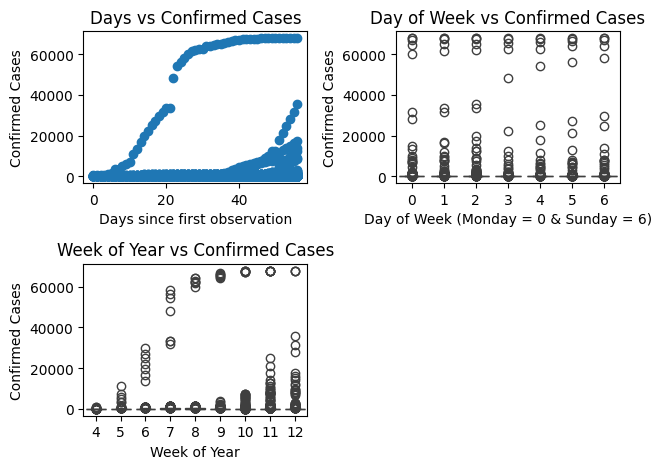

In [ ]:
plt.subplot(2, 2, 1)
plt.scatter(df['days_passed'], df['confirmed'])
plt.title('Days vs Confirmed Cases')
plt.xlabel('Days since first observation')
plt.ylabel('Confirmed Cases')


plt.subplot(2, 2, 2)
sns.boxplot(x = 'day_of_week', y = 'confirmed', data = df)
plt.title("Day of Week vs Confirmed Cases")
plt.xlabel('Day of Week (Monday = 0 & Sunday = 6)')
plt.ylabel('Confirmed Cases')

plt.subplot(2, 2, 3)
sns.boxplot(x = 'week_of_year', y = 'confirmed', data = df)
plt.title("Week of Year vs Confirmed Cases")
plt.xlabel('Week of Year')
plt.ylabel('Confirmed Cases')

plt.tight_layout()
plt.show()

In [ ]:
def plot_heatmap(df, columns):
  corr = df[columns].corr()
  plt.figure(figsize=(10, 8))
  sns.heatmap(corr, annot=True, cmap='coolwarm')
  plt.title('Correlation Heatmap')
  plt.show()

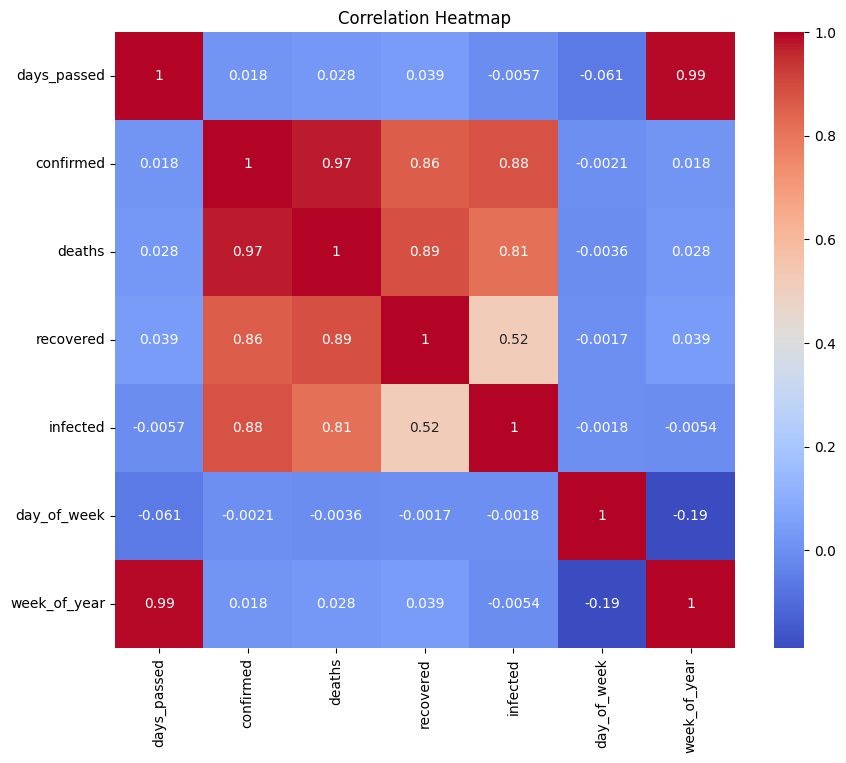

In [ ]:
lst = ['days_passed', 'confirmed', 'deaths', 'recovered', 'infected', 'day_of_week', 'week_of_year']
plot_heatmap(df, lst)

Voila!
The dataset needs a severe outlier treatment process especially for the columns deaths, recovered, infected.

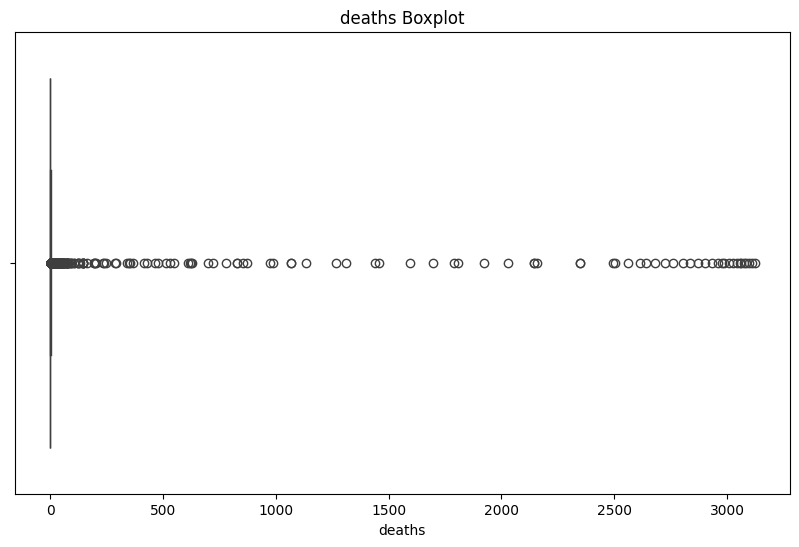

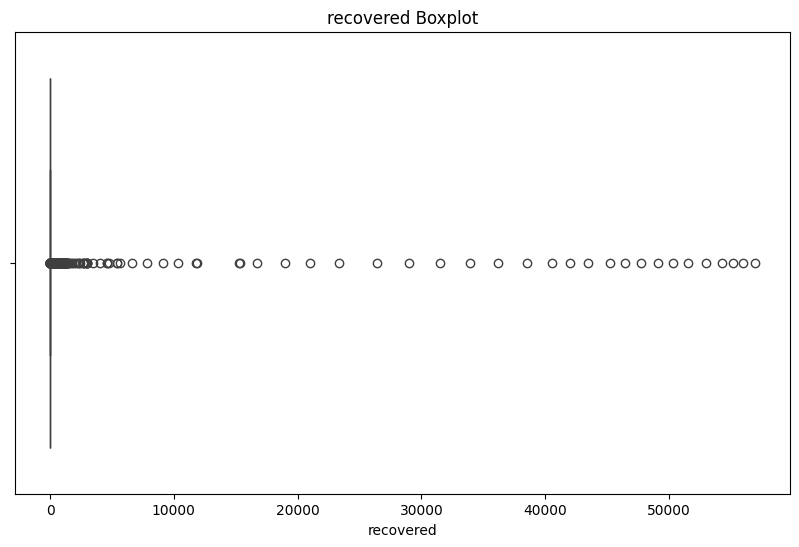

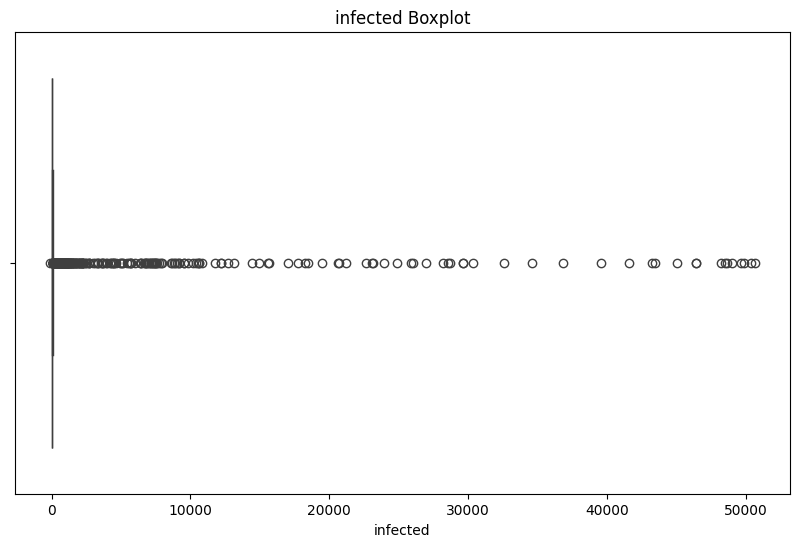

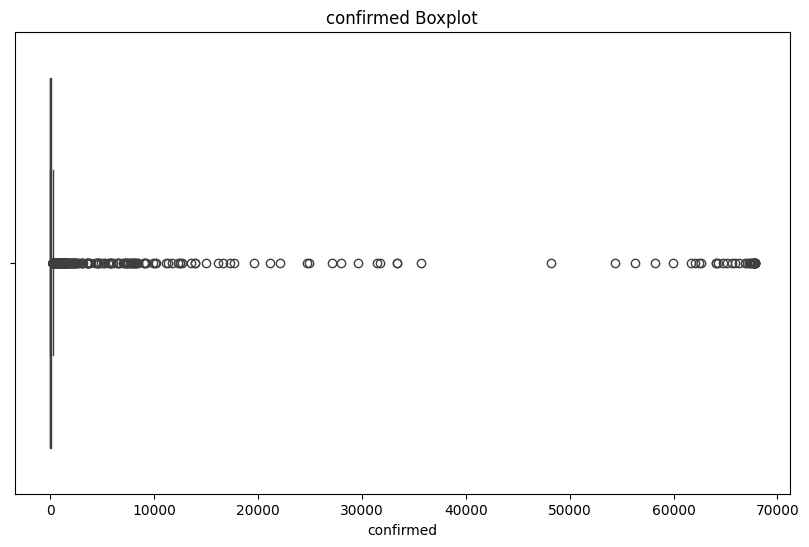

In [ ]:
cls = ['deaths', 'recovered', 'infected', 'confirmed']
for col in cls:
  plt.figure(figsize = (10, 6))
  sns.boxplot(x = col, data = df)
  plt.title(f'{col} Boxplot')
  plt.show

Then, IQR method can be used for outlier detection & treatment.

In [ ]:
def iqr_out(df, col, command):
  q1 = df[col].quantile(0.25)
  q3 = df[col].quantile(0.75)
  iqr = q3 - q1
  lower_bound = q1 - 1.5 * iqr
  upper_bound = q3 + 1.5 * iqr
  if command == 'replace':
    df[col] = np.where(df[col] > upper_bound, upper_bound, df[col])
    df[col] = np.where(df[col] < lower_bound, lower_bound, df[col])
  elif command == 'drop':
    df = df[(df[col] >= lower_bound) & (df[col] <= upper_bound)]
  return df

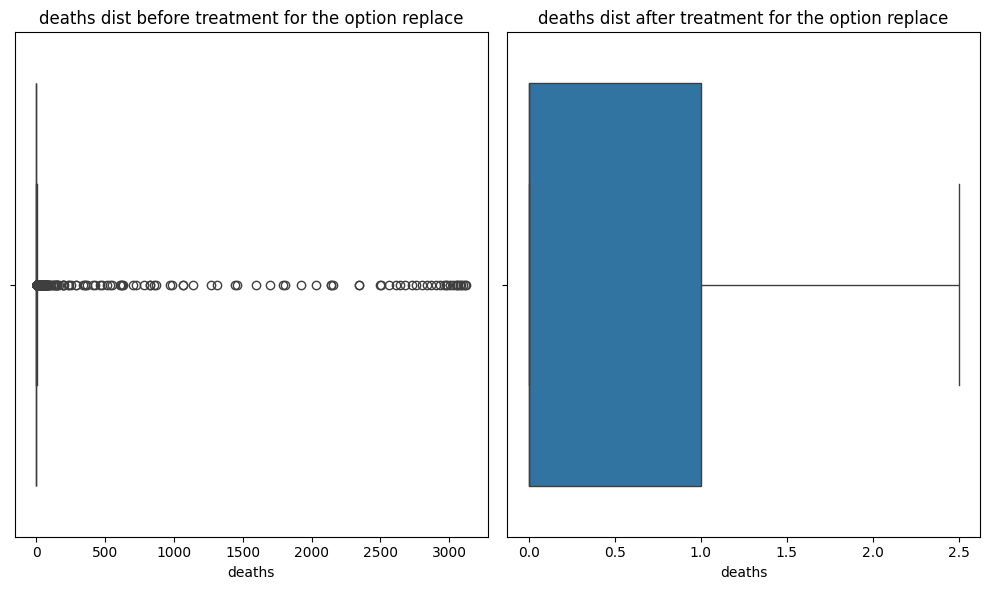

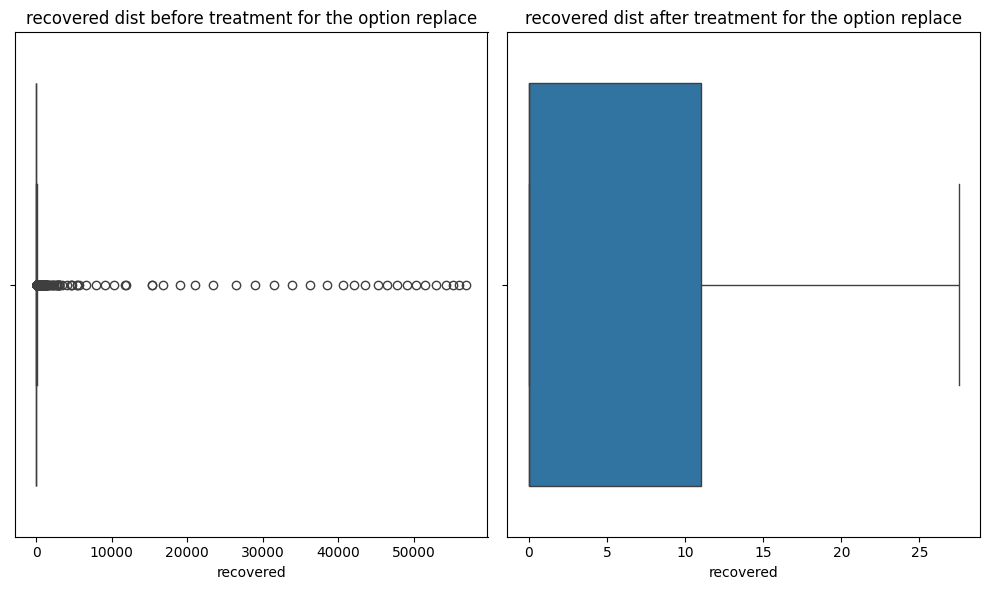

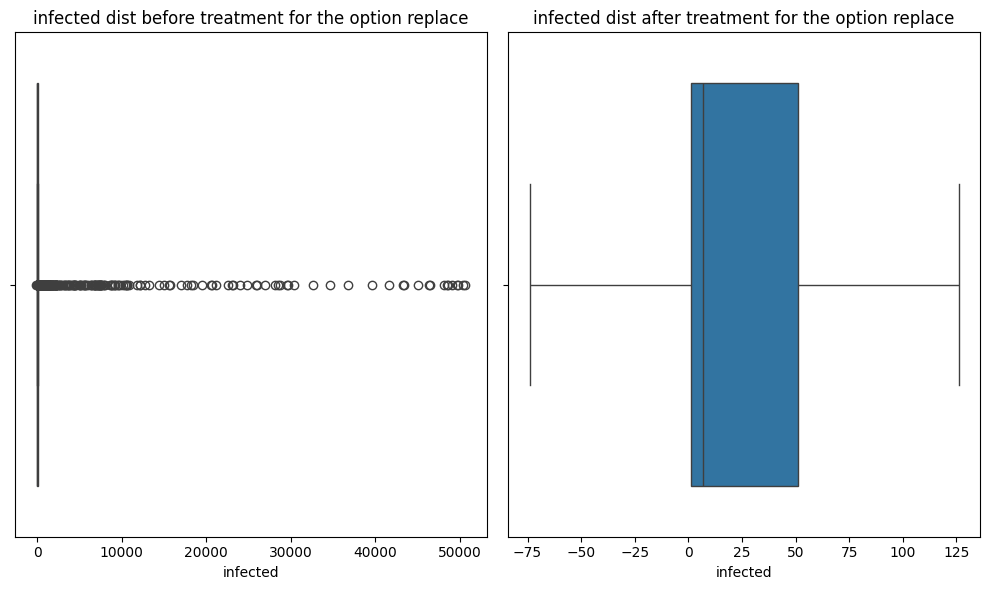

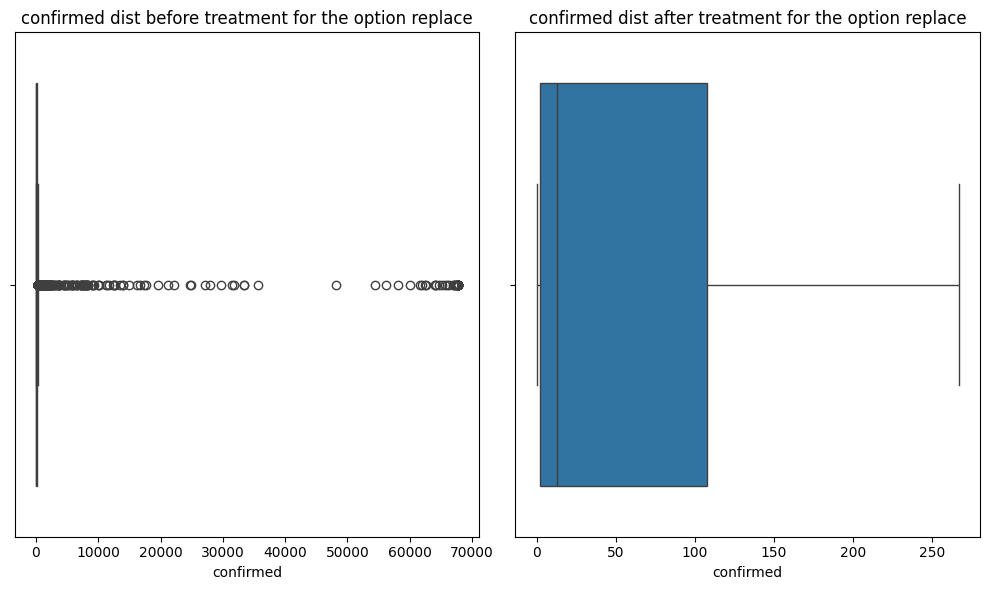

In [ ]:
df_rep = df.copy()
for col in cls:
  df_rep = iqr_out(df_rep, col, 'replace')
  plt.figure(figsize = (10, 6))
  plt.subplot(1, 2, 1)
  sns.boxplot(x = df[col])
  plt.title(f'{col} dist before treatment for the option replace')
  plt.subplot(1, 2, 2)
  sns.boxplot(x = df_rep[col])
  plt.title(f'{col} dist after treatment for the option replace')
  plt.tight_layout()
  plt.show()

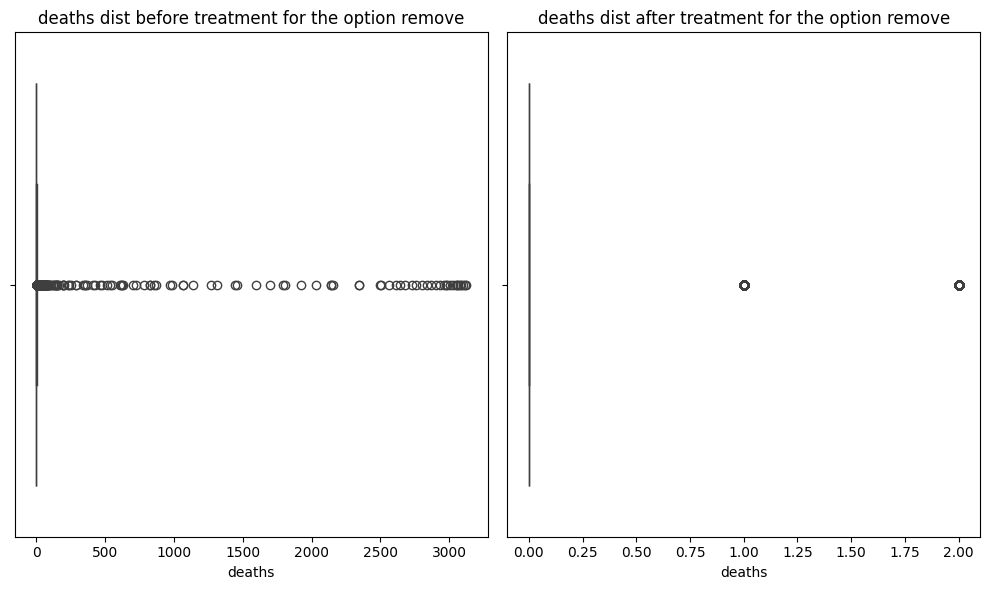

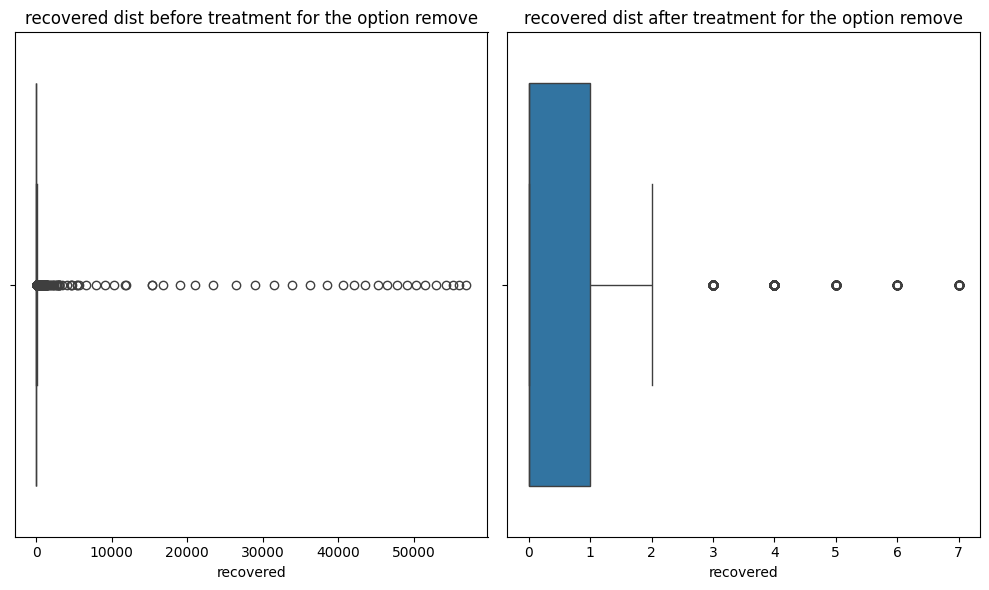

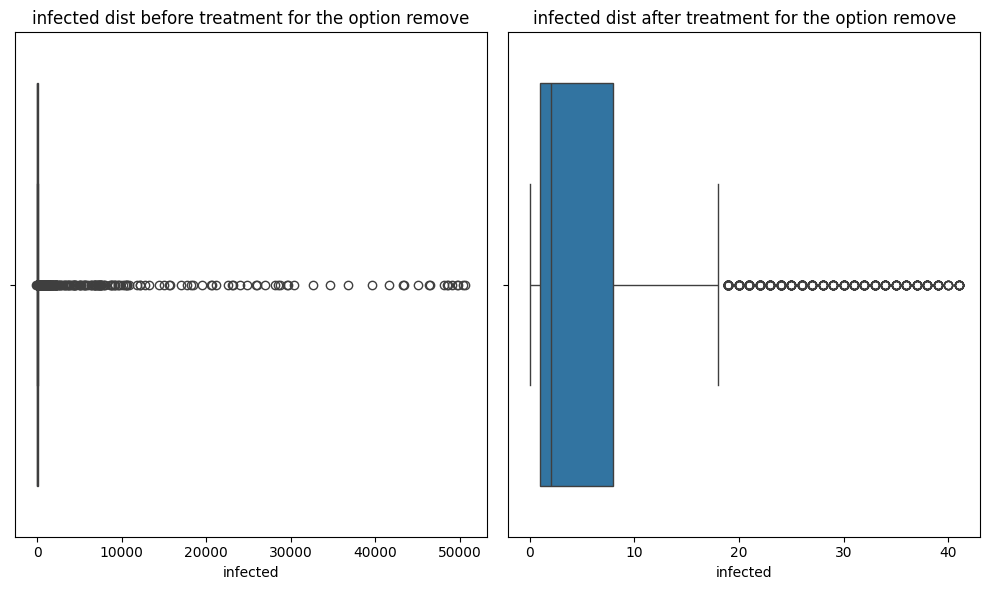

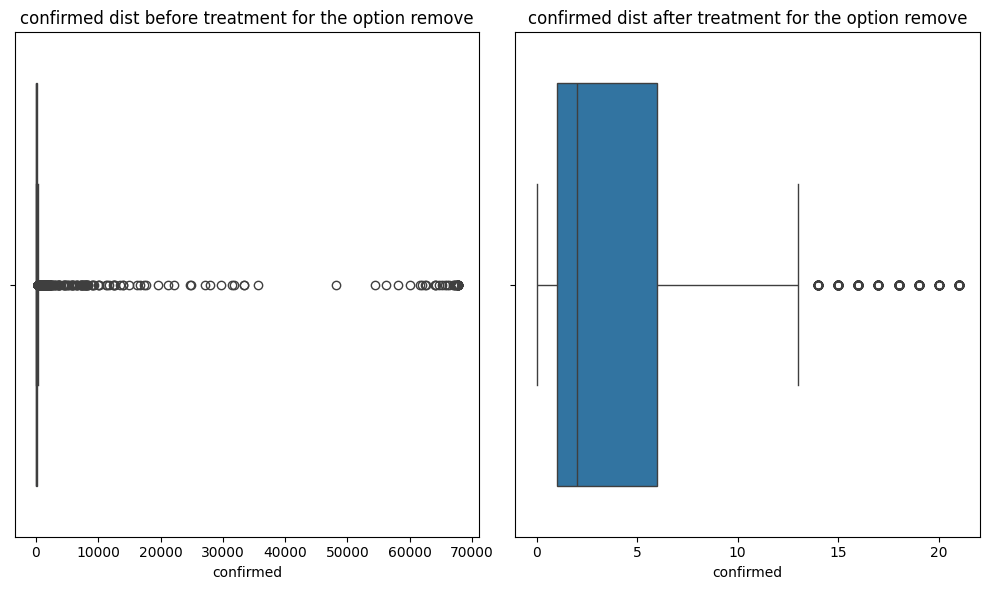

In [ ]:
df_drop = df.copy()
for col in cls:
  df_drop = iqr_out(df_drop, col, 'drop')
  plt.figure(figsize = (10, 6))
  plt.subplot(1, 2, 1)
  sns.boxplot(x = df[col])
  plt.title(f'{col} dist before treatment for the option remove')
  plt.subplot(1, 2, 2)
  sns.boxplot(x = df_drop[col])
  plt.title(f'{col} dist after treatment for the option remove')
  plt.tight_layout()
  plt.show()

In [ ]:
df.describe()

,sno,observation_date,last_update,confirmed,deaths,recovered,days_passed,day_of_week,week_of_year,infected
count,6722.000000,6722,6722,6722.000000,6722.000000,6722.000000,6722.000000,6722.000000,6722.0,6722.000000
mean,3361.500000,2020-02-28 06:25:35.971437056,2020-02-26 23:27:19.622434048,601.195924,19.855846,226.341267,37.267777,2.929634,9.191163,354.998810
min,1.000000,2020-01-22 00:00:00,2020-01-22 17:00:00,0.000000,0.000000,0.000000,0.000000,0.000000,4.0,-105.000000
25%,1681.250000,2020-02-17 00:00:00,2020-02-12 14:43:03,2.000000,0.000000,0.000000,26.000000,1.000000,8.0,1.000000
50%,3361.500000,2020-03-04 00:00:00,2020-03-03 03:33:02,13.000000,0.000000,0.000000,42.000000,3.000000,10.0,7.000000
75%,5041.750000,2020-03-12 00:00:00,2020-03-11 20:00:00,108.000000,1.000000,11.000000,50.000000,5.000000,11.0,51.000000
max,6722.000000,2020-03-18 00:00:00,2020-03-18 19:53:03,67800.000000,3122.000000,56927.000000,56.000000,6.000000,12.0,50633.000000
std,1940.618587,NaN,NaN,4896.332140,204.486922,2556.035202,15.530801,2.034362,2.255162,2830.258167


In [ ]:
df_drop.describe()

,sno,observation_date,last_update,confirmed,deaths,recovered,days_passed,day_of_week,week_of_year,infected
count,3724.000000,3724,3724,3724.000000,3724.000000,3724.000000,3724.000000,3724.000000,3724.0,3724.000000
mean,3269.074382,2020-02-27 11:07:01.482277120,2020-02-24 23:41:26.437164288,4.520408,0.046187,0.398496,36.463212,2.965091,9.07116,4.075725
min,1.000000,2020-01-22 00:00:00,2020-01-22 17:00:00,0.000000,0.000000,0.000000,0.000000,0.000000,4.0,0.000000
25%,1629.750000,2020-02-16 00:00:00,2020-02-09 06:50:35.750000128,1.000000,0.000000,0.000000,25.000000,1.000000,7.0,1.000000
50%,3349.500000,2020-03-04 00:00:00,2020-03-02 03:43:02,2.000000,0.000000,0.000000,42.000000,3.000000,10.0,2.000000
75%,4809.250000,2020-03-11 00:00:00,2020-03-10 05:13:07,6.000000,0.000000,0.000000,49.000000,5.000000,11.0,6.000000
max,6722.000000,2020-03-18 00:00:00,2020-03-18 19:53:03,21.000000,2.000000,7.000000,56.000000,6.000000,12.0,21.000000
std,1898.049675,NaN,NaN,5.138100,0.216221,0.993212,15.746378,2.041963,2.283208,4.945272


In [ ]:
df_rep.describe()

,sno,observation_date,last_update,confirmed,deaths,recovered,days_passed,day_of_week,week_of_year,infected
count,6722.000000,6722,6722,6722.000000,6722.000000,6722.000000,6722.000000,6722.000000,6722.0,6722.000000
mean,3361.500000,2020-02-28 06:25:35.971437056,2020-02-26 23:27:19.622434048,69.731479,0.519786,6.999182,37.267777,2.929634,9.191163,33.574383
min,1.000000,2020-01-22 00:00:00,2020-01-22 17:00:00,0.000000,0.000000,0.000000,0.000000,0.000000,4.0,-74.000000
25%,1681.250000,2020-02-17 00:00:00,2020-02-12 14:43:03,2.000000,0.000000,0.000000,26.000000,1.000000,8.0,1.000000
50%,3361.500000,2020-03-04 00:00:00,2020-03-03 03:33:02,13.000000,0.000000,0.000000,42.000000,3.000000,10.0,7.000000
75%,5041.750000,2020-03-12 00:00:00,2020-03-11 20:00:00,108.000000,1.000000,11.000000,50.000000,5.000000,11.0,51.000000
max,6722.000000,2020-03-18 00:00:00,2020-03-18 19:53:03,267.000000,2.500000,27.500000,56.000000,6.000000,12.0,126.000000
std,1940.618587,NaN,NaN,98.232563,0.908749,10.963892,15.530801,2.034362,2.255162,45.862304


In [ ]:
df = df_rep.copy()

In [ ]:
df = df[df['infected'] >= 0]

In [ ]:
df['country_region'].value_counts()

country_region
Mainland China    1765
US                1387
Australia          287
Canada             208
France              91
                  ... 
Kyrgyzstan           1
Mauritius            1
Zambia               1
Djibouti             1
Gambia, The          1
Name: count, Length: 179, dtype: int64

In [ ]:
df['province_state'].value_counts()

province_state
Hebei                   59
Gansu                   59
Shanxi                  57
Macau                   57
Ningxia                 57
                        ..
Cherokee County, GA      1
Collin County, TX        1
Jefferson County, KY     1
Jefferson Parish, LA     1
Montserrat               1
Name: count, Length: 274, dtype: int64

In [ ]:
import plotly.express as px
cuts = df['province_state'].value_counts()
fig = px.bar(x = cuts.index, y = cuts.values, title = 'Top Province/State')
fig.show()

In [ ]:
import plotly.express as px
cuts = df['country_region'].value_counts()
fig = px.bar(x = cuts.index, y = cuts.values, title = 'Top 10 Country/Region')
fig.show()

NA dominates so much for province_state column. Instead of discarding those rows or setting it as simply 'Unknown', I went for filling those missing values based on probability distribution, shortly called as random sampling with replacement.

In [ ]:
province_dist = df['province_state'].value_counts(normalize = True)
province_dist.head()

province_state
Hebei      0.014929
Gansu      0.014929
Shanxi     0.014423
Macau      0.014423
Ningxia    0.014423
Name: proportion, dtype: float64

In [ ]:
missing_mask = df['province_state'].isnull()
n_missing = missing_mask.sum()
fill_values = np.random.choice(province_dist.index, size = n_missing, p = province_dist.values)
df.loc[missing_mask, 'province_state'] = fill_values

In [ ]:
province_dist = df['province_state'].value_counts(normalize = True)
province_dist.head()

province_state
Liaoning                        0.016664
Shanxi                          0.016515
Beijing                         0.016218
Inner Mongolia                  0.015623
Diamond Princess cruise ship    0.015623
Name: proportion, dtype: float64

In [ ]:
import plotly.express as px
cuts = df['province_state'].value_counts()
fig = px.bar(x = cuts.index, y = cuts.values, title = 'Top Province/State')
fig.show()

In [ ]:
def frequency_enc(df, col):
  freq_encoding = df[col].value_counts(normalize = True)
  df[col] = df[col].map(freq_encoding)
  return df[col].map(freq_encoding)

df['province_state_freq'] = df['province_state'].map(df['province_state'].value_counts(normalize = True))
df['country_region_freq'] = df['country_region'].map(df['country_region'].value_counts(normalize = True))

In [ ]:
df.head()

,sno,observation_date,province_state,country_region,last_update,confirmed,deaths,recovered,days_passed,day_of_week,week_of_year,infected,province_state_freq,country_region_freq
0,1,2020-01-22,Anhui,Mainland China,2020-01-22 17:00:00,1.0,0.0,0.0,0,2,4,1.0,0.013986,0.26261
1,2,2020-01-22,Beijing,Mainland China,2020-01-22 17:00:00,14.0,0.0,0.0,0,2,4,14.0,0.016218,0.26261
2,3,2020-01-22,Chongqing,Mainland China,2020-01-22 17:00:00,6.0,0.0,0.0,0,2,4,6.0,0.014432,0.26261
3,4,2020-01-22,Fujian,Mainland China,2020-01-22 17:00:00,1.0,0.0,0.0,0,2,4,1.0,0.014879,0.26261
4,5,2020-01-22,Gansu,Mainland China,2020-01-22 17:00:00,0.0,0.0,0.0,0,2,4,0.0,0.013837,0.26261


In [ ]:
df['month'] = df['observation_date'].dt.month

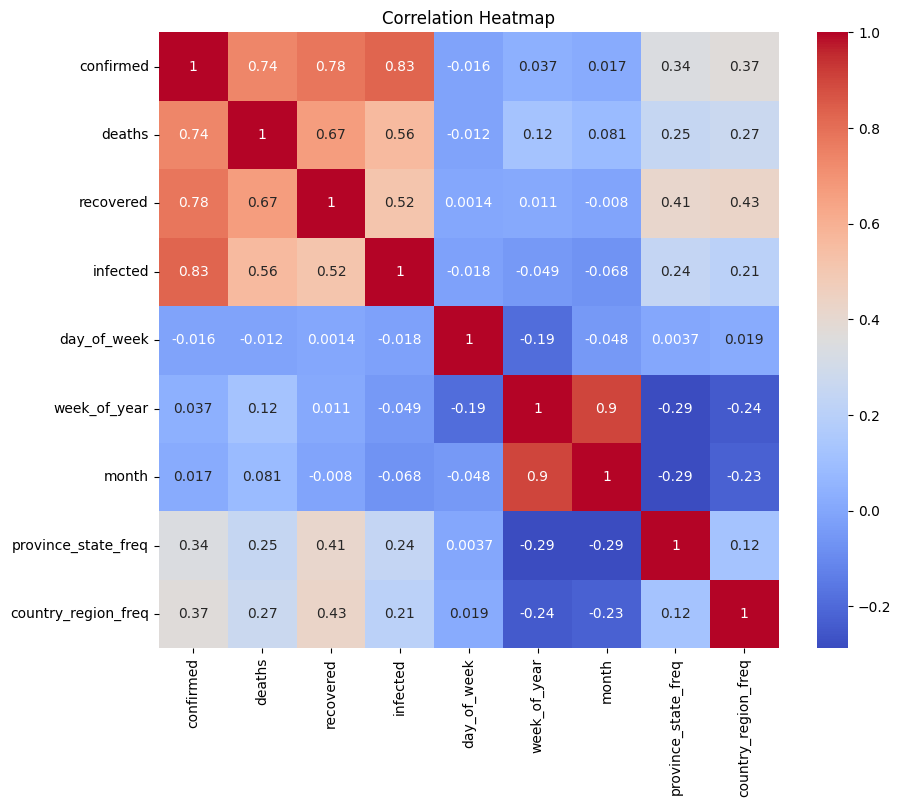

In [ ]:
lst = ['confirmed', 'deaths', 'recovered', 'infected', 'day_of_week', 'week_of_year', 'month', 'province_state_freq', 'country_region_freq']
plot_heatmap(df, lst)

In [ ]:
X = df[['month', 'days_passed', 'day_of_week', 'week_of_year', 'province_state_freq', 'country_region_freq']]

In [ ]:
def feature_prep(df, target):
  feats = ['days_passed', 'month', 'day_of_week', 'week_of_year', 'province_state_freq', 'country_region_freq']
  targets = ['confirmed', 'deaths', 'recovered',]
  for i in targets:
    if i!=target:
      feats.append(i)
  return feats

In [ ]:
feature_prep(df.iloc[:3, :], 'confirmed')

['days_passed',
 'month',
 'day_of_week',
 'week_of_year',
 'province_state_freq',
 'country_region_freq',
 'deaths',
 'recovered']

In [ ]:
def model_dev(X, y, target):
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)
  scaler = StandardScaler()
  X_train_scaled = scaler.fit_transform(X_train)
  X_test_scaled = scaler.transform(X_test)

  models = {
      'Linear Regression': (LinearRegression(), {}),
      'Ridge': (Ridge(), {'alpha': [0.1, 1, 3, 10, 30, 100]}),
      'Lasso': (Lasso(), {'alpha': [0.1, 1, 3, 10, 30, 100]})
  }

  results = {}

  for name, (model, params) in models.items():
    grid_search = GridSearchCV(model, params, cv = 5, scoring = 'neg_mean_squared_error')
    grid_search.fit(X_train_scaled, y_train)
    best_model = grid_search.best_estimator_
    y_pred = best_model.predict(X_test_scaled)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    rmse = np.sqrt(mse)
    results[name] = {
        'model': best_model,
        'mse': mse,
        'r2': r2,
        'rmse': rmse,
        'best_params': grid_search.best_params_
    }
    print(f"{name} MSE: {mse:.2f}, R2: {r2:.2f}, RMSE: {rmse:.2f}, Best Params: {grid_search.best_estimator_}")

  best_model_name = min(results, key=lambda x: results[x]['rmse'])
  print(f"Best Model for {target}: {best_model_name} with {results[best_model_name]['best_params']}\n")
  #print(f"\nResults: {results}")
  return results[best_model_name]['model']

In [ ]:
best_models = {}
targets = ['confirmed', 'deaths', 'recovered']
for target in targets:
  features = feature_prep(df, target)
  X = df[features]
  y = df[target]
  best_models[target] = model_dev(X, y, target)

Linear Regression MSE: 2884.31, R2: 0.69, RMSE: 53.71, Best Params: LinearRegression()
Ridge MSE: 2881.91, R2: 0.69, RMSE: 53.68, Best Params: Ridge(alpha=30)
Lasso MSE: 2882.20, R2: 0.69, RMSE: 53.69, Best Params: Lasso(alpha=0.1)
Best Model for confirmed: Ridge with {'alpha': 30}

Linear Regression MSE: 0.32, R2: 0.62, RMSE: 0.57, Best Params: LinearRegression()
Ridge MSE: 0.32, R2: 0.62, RMSE: 0.57, Best Params: Ridge(alpha=10)
Lasso MSE: 0.36, R2: 0.58, RMSE: 0.60, Best Params: Lasso(alpha=0.1)
Best Model for deaths: Linear Regression with {}

Linear Regression MSE: 37.72, R2: 0.67, RMSE: 6.14, Best Params: LinearRegression()
Ridge MSE: 37.70, R2: 0.67, RMSE: 6.14, Best Params: Ridge(alpha=10)
Lasso MSE: 37.77, R2: 0.67, RMSE: 6.15, Best Params: Lasso(alpha=0.1)
Best Model for recovered: Ridge with {'alpha': 10}



The point is that if we use all 4 variables (confirmed, deaths, recovered, and infected) as features to predict any one of them, we are unintentionally introducing a perfect multicollinearity into our model, meaning that one variables can actually be predicted from the others using a linear eqaution. The problem regarding multicollinearity is that it can lead to unstable and unreliable coefficient values in the models, which is why the high R - squared values we see might be likely due to this relationsip, rather than the model's actual predictive power. So simply, the model cheats in that case by using this "perfect" relationship instead of learning and extracting meaningful patterns from the other predictors. Then, I decided to use another approach:
1. For predicting 'confirmed':

Used 'deaths' and 'recovered' for the previous day, and other features, but not 'infected'.

2. For predicting 'deaths':

Used just predicted 'confirmed' and the previous day's recovered alongside other features.

3. For predicting 'recovered':

Used the just - predicted 'confirmed' and 'deaths' with other ones.


4. For predicting 'infected':

Used the relationship: infected = confirmed - deaths - recovered

In [ ]:
'''
def predict_next_7_days(row, best_models):
  preds = []
  curr_row = row.iloc[0].copy()

  for _ in range(7):
    next_day = pd.DataFrame({
    'days_passed': [curr_row['days_passed'] + 1],
    'month': [(curr_row['days_passed'] + 1) % 12 + 1],
    'day_of_week': [(curr_row['day_of_week'] + 1) % 7],
    'week_of_year': [((curr_row['days_passed'] + 1) // 7 + 1) % 52],
    'province_state_freq': [curr_row['province_state_freq']],
    'country_region_freq': [curr_row['country_region_freq']],
    'confirmed': [curr_row['confirmed']],
    'deaths': [curr_row['deaths']],
    'recovered': [curr_row['recovered']]
    })

    for target in ['confirmed', 'deaths', 'recovered']:
      features = feature_prep(curr_row, target)
      X_target = next_day[features]
      prediction = best_models[target].predict(X_target)[0]
      next_day[target] = max(0, prediction)  # ensuring non-negative predictions

    next_day['infected'] = next_day['confirmed'] - next_day['deaths'] - next_day['recovered']
    preds.append(next_day)
    curr_row = next_day.iloc[0]
  return pd.concat(preds, ignore_index = True)'''

Finally, if we want to make our model predict for the next 7 days, we actually need to provide a readily available row from the dataset, as we have already made new features and many modifications based on the original one. However, it is possible to implement by building data pipelines without taking that random row selection way. Most importantanly, the best algorithm choices here would be from LSTM, Random Forest, Ensemble Methods or time series specific models, not likely regression ones. Although our models have a r - squared value in 0.6 and 0.7 range for each target variable, it is not likely to provide robust results in the scenarios for regression - based models. On top of that, data quality issue needs to highlighted, features given seem and perform not enough to enhance the models' predictive power.